In [2]:
import numpy as np
import matplotlib.pylab as plt
from skimage import io
from skimage import img_as_uint

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from stretchablecorr import *
import filetools as ft

cube, image_names = ft.load_image_sequence('./images/')

Image sequence:
 24 frames
 1392*1024 pixels
 memory size: 261 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  60p000278.TIF


In [3]:
window_half_size = 120
xy_center = 700, 600

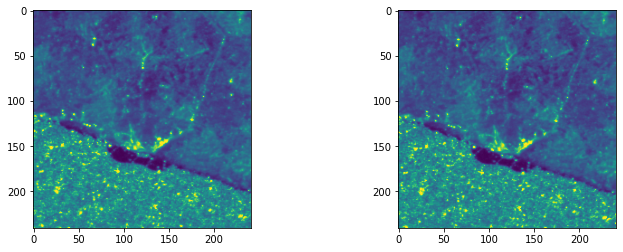

In [7]:
A, xy0 = crop(cube[3], xy_center, window_half_size)
B, xy0 = crop(cube[8], xy_center, window_half_size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);

In [10]:
shift, hess_inv = phase_registration_optim(A, B, phase=True)
print(shift)

shift, _, _ = phase_cross_correlation(A, B, upsample_factor=100)
print(shift)

[ 1.51639927 -0.97406585]
[-1.53  0.95]


In [11]:
from phase_opti import fft_translate

In [12]:
#def compare(A, B, shift)
#shift = np.array([-1.74936478,  0.58937963])
#shift = np.array([-3.15,  0.55])
shift = shift
print(shift)
B_tr = fft_translate(B, *shift)
diff = (A - B_tr)**2
i_slicing = np.s_[max(0, int(np.ceil(shift[0]))):min(0, int(np.floor(shift[0])))-1]
j_slicing = np.s_[max(0, int(np.ceil(shift[1]))):min(0, int(np.floor(shift[1])))-1]

diff = diff[i_slicing, j_slicing]
print('==========')
print(f'{np.sum(diff):e}')

[-1.53  0.95]
9.975740e+08


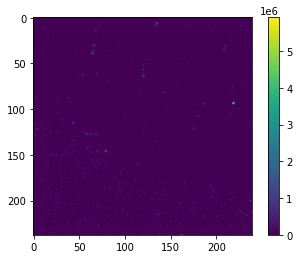

In [13]:
plt.imshow(diff); plt.colorbar();

In [14]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import fftn, ifftn
from scipy.fft import fftshift, fftfreq
from scipy.signal.windows import blackman

In [17]:
upsamplefactor=1
phase=True

if phase:
    u = blackman(A.shape[0])
    v = blackman(A.shape[1])
    window = u[:, np.newaxis] * v[np.newaxis, :]
else:
    window = 1

a, b = fftn(A * window), fftn(B * window)

ab = a * b.conj()
if phase:
    ab = ab / np.abs(ab)
phase_corr = ifftn(fftshift(ab),
                   s=upsamplefactor*np.array(ab.shape))
phase_corr = np.abs( fftshift(phase_corr) )

dx_span = fftshift( fftfreq(phase_corr.shape[1]) )*A.shape[1]
dy_span = fftshift( fftfreq(phase_corr.shape[0]) )*A.shape[0]

# argmax
argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
print('argmax', f"{argmax}")

def cost(xy, ab):
    return -np.abs(dft_tensordot(ab, xy))

def jac(xy, ab):
    return -np.real(grad_dft(ab, xy))

argmax (-2.0, 1.0)


In [25]:
%%timeit
dx_span = fftshift( fftfreq(phase_corr.shape[1]) )*A.shape[1]
dy_span = fftshift( fftfreq(phase_corr.shape[0]) )*A.shape[0]

45.3 µs ± 780 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
%%timeit
res = minimize(cost, argmax, args=(ab, ), method='BFGS', tol=1e-3)#, jac=jac)
res

12.7 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
res = minimize(cost, argmax, args=(ab, ), method='BFGS', tol=1e-3, jac=jac)
res

9.71 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


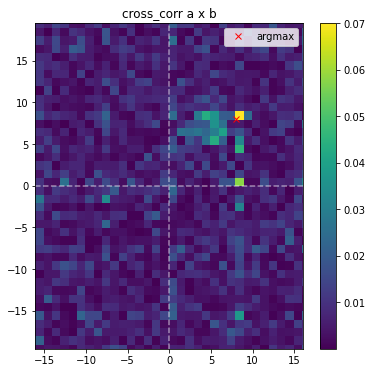

In [61]:
plt.figure(figsize=(6, 6))
#plt.pcolormesh(dx_span, dy_span, cross_corr, shading='flat');
plt.pcolormesh(dx_span, dy_span, phase_corr,
               shading='flat');
plt.axis('equal')
plt.title('cross_corr a x b'); plt.colorbar();


plt.plot(*argmax[::-1], 'xr', label='argmax');

plt.legend();plt.axvline(x=0, linestyle='--', color='white', alpha=0.5);
plt.axhline(y=0, linestyle='--', color='white', alpha=0.5);

dx, dy = 0, 0
zoom_factor = 15
plt.ylim([-A.shape[0]/zoom_factor - dy, +A.shape[0]/zoom_factor - dy ]);
plt.xlim([-A.shape[1]/zoom_factor - dx, +A.shape[1]/zoom_factor - dx]);


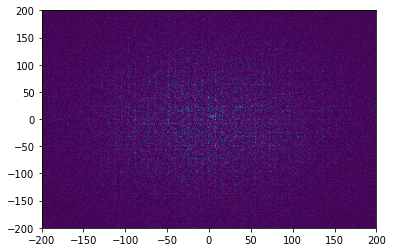

In [38]:
plt.pcolormesh(dx_span, dy_span, phase_corr)

In [ ]:
    # argmax
    argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
    argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
    #print(f"{argmax}")

    def cost(xy, ab):
        return -np.abs(dft_tensordot(ab, xy))

    def jac(xy, ab):
        return -np.real(grad_dft(ab, xy))

    res = minimize(cost, argmax, args=(ab, ), method='BFGS', tol=1e-3)#, jac=jac)
    return res.x, res.hess_inv, res